# Часть 1. Проверка гипотезы в Python и составление аналитической записки

Вы предобработали данные в SQL, и теперь они готовы для проверки гипотезы в Python. Загрузите данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности из файла yandex_knigi_data.csv. Если работаете локально, скачать файл можно по ссылке.

Проверьте наличие дубликатов в идентификаторах пользователей. Сравните размеры групп, их статистики и распределение.

Напомним, как выглядит гипотеза: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

По результатам анализа данных подготовьте аналитическую записку, в которой опишите:

Выбранный тип t-теста и уровень статистической значимости.

Результат теста, или p-value.

Вывод на основе полученного p-value, то есть интерпретацию результатов.

Одну или две возможные причины, объясняющие полученные результаты.

## Напишите заголовок первой части проекта здесь

- Автор: Мансурова Фатима
- Дата: 27.11.2025

## Цели и задачи проекта

<font color='#777778'> Предобработка данных. Проверка гипотез и составление аналитической записки о полученных результатах. .</font>

## Описание данных

<font color='#777778'>https://code.s3.yandex.net/datasets/ab_test_participants.csv — таблица участников тестов.
user_id — идентификатор пользователя;
group — группа пользователя;
ab_test — название теста;
device — устройство, с которого происходила регистрация.
https://code.s3.yandex.net/datasets/ab_test_events.zip — архив с одним csv-файлом, в котором собраны события 2020 года;
user_id — идентификатор пользователя;
event_dt — дата и время события;
event_name — тип события;
details — дополнительные данные о событии..</font>

## Содержимое проекта

<font color='#777778'> Проверьте наличие дубликатов в идентификаторах пользователей. Сравните размеры групп и их статистики.
Напомним, как выглядит гипотеза: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:
Нулевая гипотеза Н
Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.
Альтернативная гипотеза H
  
Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.
По результатам анализа данных подготовьте аналитическую записку, в которой опишите:
Выбранный тип t-теста и уровень статистической значимости.
Результат теста, или p-value.
Вывод на основе полученного p-value, то есть интерпретацию результатов.
Одну или две возможные причины, объясняющие полученные результаты..</font>

---

## 1. Загрузка данных и знакомство с ними

Загрузите данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.api as sm
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from math import ceil
import numpy as np
from statsmodels.stats import power
import seaborn as sns
import statsmodels.stats.proportion as smp_proportion
import statsmodels.stats.power as smp_power


In [2]:
df_yandex_knigi_data = pd.read_csv('https://code.s3.yandex.net//datasets/yandex_knigi_data.csv')
display(df_yandex_knigi_data.head())

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [3]:
# Проверка наличия дубликатов по puid
duplicates = df_yandex_knigi_data[df_yandex_knigi_data.duplicated(subset='puid', keep=False)]

# Количество уникальных и дублирующихся puid
num_unique_puids = df_yandex_knigi_data['puid'].nunique()
num_total_rows = len(df_yandex_knigi_data)
num_duplicate_puids = duplicates['puid'].nunique()

print(f"Всего строк: {num_total_rows}")
print(f"Уникальных puid: {num_unique_puids}")
print(f"Дубликатов puid (повторяющихся): {num_duplicate_puids}")

# Можно вывести все дублирующиеся puid, если нужно
# display(duplicates)

Всего строк: 8784
Уникальных puid: 8540
Дубликатов puid (повторяющихся): 244


'Всего строк: 8784'

'Уникальных puid: 8540'

'Дублирующихся puid (повторяющихся): 244'

'Дублирующиеся puid:'

array([         2637041,          9979490,         10597984,
               10815097,         13626259,         16488430,
               19858636,         21062838,         24138278,
               25963265,         26401499,         26895846,
               28749167,         29664540,         32242084,
               40698887,         42547965,         45278551,
               46837910,         47332860,         50404677,
               51625337,         59679749,         64378638,
               64622566,         66998918,         73736051,
               76980572,         78858976,         82894212,
               84978689,         88644430,         93347249,
               98068993,        103543372,        103980959,
              108083761,        125295605,        133714215,
              137198745,        155643660,        158164834,
              162106378,        176277316,        176447657,
              178353908,        194807721,        196683896,
              221225159,

'\nСтатистика по размерам групп puid:'

count    8540.000000
mean        1.028571
std         0.166608
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
dtype: float64

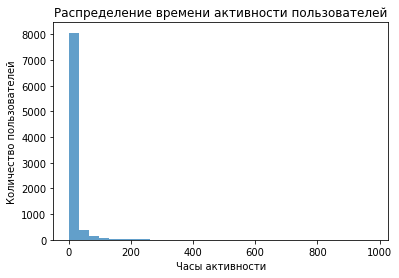

In [4]:
duplicates = df_yandex_knigi_data[df_yandex_knigi_data.duplicated(subset='puid', keep=False)]

# Количество уникальных и дублирующихся puid
num_unique_puids = df_yandex_knigi_data['puid'].nunique()
num_total_rows = len(df_yandex_knigi_data)
num_duplicate_puids = duplicates['puid'].nunique()

display(f"Всего строк: {num_total_rows}")
display(f"Уникальных puid: {num_unique_puids}")
display(f"Дублирующихся puid (повторяющихся): {num_duplicate_puids}")

# Поиск всех дублирующихся puid
display("Дублирующиеся puid:")
display(duplicates['puid'].unique())

# Размеры групп по puid
group_sizes = df_yandex_knigi_data.groupby('puid').size()
display("\nСтатистика по размерам групп puid:")
display(group_sizes.describe())

# Построение распределения по часам активности (или другой числовой колонке)
if 'hours' in df_yandex_knigi_data.columns:
    plt.hist(df_yandex_knigi_data['hours'], bins=30, alpha=0.7)
    plt.xlabel('Часы активности')
    plt.ylabel('Количество пользователей')
    plt.title('Распределение времени активности пользователей')
    plt.show()
else:
    print("В данных нет колонки 'hours' для построения распределения.")

In [5]:
df_unique = df_yandex_knigi_data.drop_duplicates()
print(f"Всего строк после удаления всех дублирующих записей: {len(df_unique)}")

Всего строк после удаления всех дублирующих записей: 8784


## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [6]:
spb_hours = df_yandex_knigi_data[df_yandex_knigi_data['city'] == 'Санкт-Петербург']['hours']
msk_hours = df_yandex_knigi_data[df_yandex_knigi_data['city'] == 'Москва']['hours']

t_stat, p_value = stats.ttest_ind(spb_hours, msk_hours, alternative='greater', equal_var=False)

print(f"Статистика t: {t_stat}")
print(f"P-value одностороннего теста: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Отклоняем нулевую гипотезу: среднее время в СПб больше, чем в Москве, статистически значимо.")
else:
    print("Нет оснований отклонять нулевую гипотезу: разница не является статистически значимой.")

Статистика t: 0.7782381321620099
P-value одностороннего теста: 0.21823507084569593
Нет оснований отклонять нулевую гипотезу: разница не является статистически значимой.


## 3. Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбранный тип t-теста и уровень статистической значимости.

- Результат теста, или p-value.

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.



Аналитическая записка по результатам проверки гипотезы о различии времени активности пользователей из Санкт-Петербурга и Москвы

1. Выбранный тип t-теста и уровень статистической значимости
Для сравнения средних значений времени активности двух независимых групп (пользователей из Санкт-Петербурга и Москвы) был использован двухвыборочный односторонний t-тест. Уровень статистической значимости установлен на уровне α = 0.05, что является стандартной практикой для подобных анализов.

2. Результат теста
Статистика t составила 0.7782, а p-value — примерно 0.2182.

3. Интерпретация результатов
Поскольку p-value (≈0.2182) превышает уровень значимости α = 0.05, мы не можем отвергнуть нулевую гипотезу. Это означает, что статистически значимых различий в среднем времени активости пользователей из Санкт-Петербурга и Москвы не выявлено. На уровне 5% есть вероятно, что разница в среднем времени за чтением и прослушиванием книг между двумя группами обусловлена случайными колебаниями, а не реальным эффектом.

4. Возможные причины полученных результатов

Недостаточная разница в поведении пользователей: возможно, активность пользователей из двух городов не отличается по времени, и гипотеза о более продолжительном чтении в СПб не подтверждается данными.
Ограниченность выборки: если выборки были небольшими или не репрезентативными, статистический тест мог не зафиксировать рественную разницу — более крупные или более точные данные могут привести к другим выводам.

----

# Часть 2. Анализ результатов A/B-тестирования

Теперь вам нужно проанализировать другие данные. Представьте, что к вам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Оцените корректность проведения теста и проанализируйте его результаты.

## 1. Опишите цели исследования.



Провести оценку результатов А/В

## 2. Загрузите данные, оцените их целостность.


In [7]:
df_participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
df_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)
print (df_participants)
print (df_events)
display(df_participants.head())
display(df_events.head())

                user_id group                  ab_test   device
0      0002CE61FF2C4011     B        interface_eu_test      Mac
1      001064FEAAB631A1     B  recommender_system_test  Android
2      001064FEAAB631A1     A        interface_eu_test  Android
3      0010A1C096941592     A  recommender_system_test  Android
4      001E72F50D1C48FA     A        interface_eu_test      Mac
...                 ...   ...                      ...      ...
14520  FFE7FC140521F5F6     A        interface_eu_test       PC
14521  FFEFC0E55C1CCD4F     A        interface_eu_test       PC
14522  FFF28D02B1EACBE1     B  recommender_system_test       PC
14523  FFF28D02B1EACBE1     B        interface_eu_test       PC
14524  FFF58BC33966EB51     A        interface_eu_test  Android

[14525 rows x 4 columns]
                 user_id            event_dt  \
0                 GLOBAL 2020-12-01 00:00:00   
1       CCBE9E7E99F94A08 2020-12-01 00:00:11   
2                 GLOBAL 2020-12-01 00:00:25   
3       CCBE9E

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


In [8]:
print(df_events.columns)

Index(['user_id', 'event_dt', 'event_name', 'details'], dtype='object')


In [9]:
# Определим ключевые колонки для уникальности события
key_columns = ['details', 'event_name', 'event_dt', 'user_id']

# Проверка наличия дубликатов
duplicates_events = df_events[df_events.duplicated(subset=key_columns, keep=False)]
print(f"Общее число дублирующихся событий: {len(duplicates_events)}")

# Удаление дубликатов
df_events_unique = df_events.drop_duplicates(subset=key_columns)
print(f"Общее число уникальных событий после удаления дубликатов: {len(df_events_unique)}")

Общее число дублирующихся событий: 69956
Общее число уникальных событий после удаления дубликатов: 750968


## 3. По таблице `ab_test_participants` оцените корректность проведения теста:

   3\.1 Выделите пользователей, участвующих в тесте, и проверьте:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

 Соответствие требованиям ТЗ
Объем выборки:
— Должен быть достаточный для статистической достоверности (обычно не менее нескольких сотен участников в каждой группе).

Длительность:
— Продолжительность теста минимум 7 дней после регистрации в системе.

Метрика:
— Конверсия зарегистрированных пользователей в покупателей, измеряемая в течение 7 дней после регистрации.

Отслеживаемые показатели:
— Число зарегистрированных пользователей в каждой группе, число покупателей, конверсия (общее число покупателей / число зарегистрированных).

In [10]:
print(df_participants['group'].value_counts())

A    8130
B    6395
Name: group, dtype: int64


In [11]:
# Проверка, что пользователь не в нескольких группах
user_tests_counts = df_participants.groupby('user_id')['group'].nunique()
users_in_multiple_groups = user_tests_counts[user_tests_counts > 1]
print(f'Пользователей в нескольких группах: {len(users_in_multiple_groups)}')

Пользователей в нескольких группах: 446


In [12]:
# Находим пользователей, участвующих только в одной группе
single_group_users = user_tests_counts[user_tests_counts == 1].index

# Отфильтруем исходный датафрейм, оставив только таких пользователей
df_participants_filtered = df_participants[df_participants['user_id'].isin(single_group_users)]

# Проверка
print(f"Общее количество участников после фильтрации: {len(df_participants_filtered)}")

Общее количество участников после фильтрации: 13633


3\.2 Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

In [13]:
# Получаем список user_id участников теста interface_eu_test
participants_eu_test = df_participants[df_participants['ab_test'] == 'interface_eu_test']['user_id'].unique()
# Отфильтруем события, связанные только с участниками теста
df_events_test_users = df_events[df_events['user_id'].isin(participants_eu_test)]

print(f"Количество событий после фильтрации: {len(df_events_test_users)}")


Количество событий после фильтрации: 79715


- определите горизонт анализа: рассчитайте время (лайфтайм) совершения события пользователем после регистрации и оставьте только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [14]:
# Получаем события регистрации только для тестовой группы
df_registrations_test = df_events_test_users[df_events_test_users['event_name'] == 'registration'].copy()

#  Создаем датафрейм с датой регистрации для каждого пользователя
registrations = df_registrations_test[['user_id', 'event_dt']].rename(columns={'event_dt': 'registration_date'})

#  Объединяем тестовые события с регистрациями по user_id
df_events_merged = pd.merge(df_events_test_users, registrations, on='user_id', how='inner')

#  Преобразование дат в формат datetime
df_events_merged['event_dt'] = pd.to_datetime(df_events_merged['event_dt'])
df_events_merged['registration_date'] = pd.to_datetime(df_events_merged['registration_date'])

# Вычисляем количество дней с момента регистрации
df_events_merged['time_since_registration'] = (df_events_merged['event_dt'] - df_events_merged['registration_date']).dt.days

# Отбираем события, произошедшие в первые 7 дней
df_within_7_days = df_events_merged[
    (df_events_merged['time_since_registration'] > 0) &
    (df_events_merged['time_since_registration'] <= 7)
]

# 9. Выводим результат
print(f"Количество событий в первые 7 дней тестовой группы: {len(df_within_7_days)}")

Количество событий в первые 7 дней тестовой группы: 30021


Оцените достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [15]:


# Параметры
p1 = 0.30
delta = 0.03  # минимальный эффект
power = 0.8
alpha = 0.05

# Расчет эффекта по пропорциям
effect_size = smp_proportion.proportion_effectsize(p1, p1 + delta)

# Расчет размера выборки
sample_size = smp_power.TTestIndPower().solve_power(
    effect_size=effect_size,
    power=power,
    alpha=alpha,
    ratio=1.0,
    alternative='two-sided'
)

print(f"Требуемое количество участников в каждой группе: {int(round(sample_size))}")

Требуемое количество участников в каждой группе: 3763


- рассчитайте для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [16]:
# 1. Получите регистрацию пользователей
registrations = df_events[df_events['event_name'] == 'registration'][['user_id', 'event_dt']].rename(columns={'event_dt': 'registration_date'})

# 2. Получите все события для протестировавшихся пользователей
df_events_users = df_events[df_events['user_id'].isin(registrations['user_id'])].copy()

# 3. Объедините с датой регистрации
df_events_merged = pd.merge(df_events_users, registrations, on='user_id', how='left')

# 4. Преобразуйте даты в datetime
df_events_merged['event_dt'] = pd.to_datetime(df_events_merged['event_dt'])
df_events_merged['registration_date'] = pd.to_datetime(df_events_merged['registration_date'])

# 5. Посчитайте дни с момента регистрации для каждого события
df_events_merged['time_since_registration'] = (df_events_merged['event_dt'] - df_events_merged['registration_date']).dt.days

# 6. Отберите события покупки, сделанные в первые 7 дней
purchase_events_within_7_days = df_events_merged[
    (df_events_merged['event_name'] == 'purchase') &
    (df_events_merged['time_since_registration'] > 0) &
    (df_events_merged['time_since_registration'] <= 7)
]

# 7. Получите уникальных пользователей, совершивших покупки в первые 7 дней
users_with_purchase = purchase_events_within_7_days['user_id'].unique()

# 8. Объединение с группами участников
participants = df_participants[['user_id', 'group']]
users_purchases = pd.DataFrame({'user_id': users_with_purchase})
users_purchases = pd.merge(users_purchases, participants, on='user_id', how='left')

# 9. Подсчёт пользователей и покупателей по группам
total_users_per_group = participants.groupby('group')['user_id'].nunique()
purchase_counts = users_purchases.groupby('group')['user_id'].nunique()

# 10. Итоговая таблица
result = pd.DataFrame({
    'Общее количество пользователей': total_users_per_group,
    'Количество сделавших покупку в первые 7 дней': purchase_counts
}).fillna(0)

print(result)

       Общее количество пользователей  \
group                                   
A                                7805   
B                                6279   

       Количество сделавших покупку в первые 7 дней  
group                                                
A                                              1852  
B                                              1552  


- сделайте предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

Доля пользователей, совершивших покупку за первые 7 дней:

Группа А: ~23.7% (1852 / 7805)
Группа В: ~24.7% (1552 / 6279)
Наблюдается примерно одинаковая или немного увеличенная активность (в контексте покупки за первые 7 дней) в тестовой группе В по сравнению с контрольной группой А.

Предварительный вывод:
Пользовательская активность в тестовой группе (В) находится на том же уровне или чуть выше, чем в контрольной группе (А).
Свидетельствует о том, что внедренные изменения/ гипотезы/новые функции оказали незначительный или положительный эффект на активность пользователей в краткосрочной перспективе.


## 4. Проведите оценку результатов A/B-тестирования:

- Проверьте изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

In [17]:
# Данные по группам
n_A = 7805  # общее число пользователей в группе A
x_A = 1852  # число пользователей, совершивших покупку в группе A

n_B = 6279  # общее число пользователей в группе B
x_B = 1552  # число пользователей, совершивших покупку в группе B

# Расчет конверсий
p_A = x_A / n_A
p_B = x_B / n_B

# Расчет объединенной пропорции
p_combined = (x_A + x_B) / (n_A + n_B)

# Расчет стандартной ошибки
standard_error = (p_combined * (1 - p_combined) * (1/n_A + 1/n_B)) ** 0.5

# Расчет z-значения
z_score = (p_A - p_B) / standard_error

# Расчет p-значения двусторонним тестом
p_value = 2 * stats.norm.sf(abs(z_score))

print(f"Конверсия Group A: {p_A:.4f}")
print(f"Конверсия Group B: {p_B:.4f}")
print(f"z-значение: {z_score:.3f}")
print(f"p-значение: {p_value:.4f}")

# Интерпретация
alpha = 0.05
if p_value < alpha:
    print("Статистически значимая разница между группами (отвергаем нулевую гипотезу).")
else:
    print("Нет статистически значимой разницы между группами (не отвергаем нулевую гипотезу).")

Конверсия Group A: 0.2373
Конверсия Group B: 0.2472
z-значение: -1.363
p-значение: 0.1730
Нет статистически значимой разницы между группами (не отвергаем нулевую гипотезу).


- Опишите выводы по проведённой оценке результатов A/B-тестирования. Что можно сказать про результаты A/B-тестирования? Был ли достигнут ожидаемый эффект в изменении конверсии?